In [ ]:
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dropout
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Инициализация NLTK (необходимо выполнить один раз)
nltk.download('punkt')
nltk.download('stopwords')
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Načítanie datasetov**

---


 train: Twitter dataset by Davidson (80%, bez podvzorkovania);
 test: Twitter dataset by Davidson (20%)

In [ ]:

train = pd.read_csv('/content/drive/MyDrive/Data/trainNO.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/test.csv')


**Predspracovanie dat **

---



In [ ]:
# Flagy pre regulárne výrazy
FLAGS = re.MULTILINE | re.DOTALL
# Funkcia pre spracovanie hashtagov

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result
# Funkcia pre spracovanie všetkých veľkých písmen

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"

# Hlavná funkcia na tokenizáciu textu

def tokenize(text):
    # Rôzne časti regulárneho výrazu pre emotikony
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # Funkcia pre nahradenie vzoru
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

     # Nahradenie URL adries reťazcom "<url>"
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    # Nahradenie znaku "/" medzerami okolo, aby sa oddelili od slov
    text = re_sub(r"/"," / ")
    # Nahradenie menčení používateľa reťazcom "<user>"
    text = re_sub(r"@\w+", "<user>")
    # Nahradenie smajlíkov reťazcom "<smile>"
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    # Nahradenie čísiel reťazcom "<number>"
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    # Nahradenie hashtagov volaním funkcie hashtag
    text = re_sub(r"#\S+", hashtag)
    # Nahradenie opakovania znakov reťazcom "<repeat>"
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    # Nahradenie zdĺžených slov reťazcom "<elong>"
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    # Nahradenie všetkých veľkých písmen reťazcom "<allcaps>"
    text = re_sub(r"([A-Z]){2,}", allcaps)

    return text.lower()

if __name__ == '__main__':
    # Testovací text
    text = "&#9733;@&#9733;@&#9733;@&#9733;@&#9733; GRAND OPENING ! &#9733;@&#9733;@&#9733;@&#9733;@&#9733; TOP CLASS &#9733; Oriental Massage &#9733; PERFECT !&#9733;/ http://t.co/ydZYr4dVS4"
    # Tokenizácia textu
    tokens = tokenize(text)
    print(tokens)

&<hashtag> <number>;@&#<number>;@&#<number>;@&#<number>;@&#<number>; grand <allcaps> opening <allcaps> ! &<hashtag> <number>;@&#<number>;@&#<number>;@&#<number>;@&#<number>; top <allcaps> class <allcaps> &<hashtag> <number>; oriental massage &<hashtag> <number>; perfect <allcaps> !&<hashtag> <number>; /  <url>


In [ ]:
# Odstránenie stĺpca 'class' z train
train_texts = train.drop('class', axis=1)

# Konverzia stĺpca 'class' na kategóriálny formát
train_labels = to_categorical(train['class'], num_classes=2)

# Odstránenie stĺpca 'class' z test
test_texts = test.drop('class', axis=1)

# Konverzia stĺpca 'class' na kategóriálny formát
test_labels = to_categorical(test['class'], num_classes=2)


In [ ]:
# Aplikácia funkcie preprocess na train_texts a test_texts
train_texts['tweet'] = preprocess(train_texts['tweet'])

test_texts['tweet'] = preprocess(test_texts['tweet'])


**CNN**

---
Parametre modelu

In [ ]:

VOCAB_SIZE = 10000
MAX_LENGTH = 734
EMBEDDING_DIM = 200
FILTERS = 256
KERNEL_SIZE = 5
HIDDEN_UNITS = 128
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_texts['tweet'])
# Príprava textových komentárov na numerické sekvencie pomocou tokenizeru.
sequences = tokenizer.texts_to_sequences(train_texts['tweet'])

# Zarovnanie numerických sekvencií na maximálnu dĺžku, ktorú určuje MAX_LENGTH.
data = pad_sequences(sequences, maxlen=MAX_LENGTH)

In [ ]:
# Vytvorenie sekvenčného modelu
model = Sequential()

# Pridanie vrstvy embeddingu na mapovanie slov na vektory a určenie vstupnej dĺžky sekvencií
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH))

# Pridanie vrstvy dropout na redukciu pretrénovania
model.add(Dropout(0.5))

# Pridanie konvolučnej vrstvy s RELU aktiváciou na extrakciu rôznych charakteristík z textu
model.add(Conv1D(FILTERS, KERNEL_SIZE, activation='relu'))

# Pridanie vrstvy max-poolingu na získanie najvýznamnejších charakteristík
model.add(MaxPooling1D(pool_size=2))

# Pridanie vrstvy global max-poolingu na extrakciu najvýznamnejšej črty zo všetkých čŕt
model.add(GlobalMaxPooling1D())

# Pridanie skrytej vrstvy s RELU aktiváciou
model.add(Dense(HIDDEN_UNITS, activation='relu'))

# Pridanie výstupnej vrstvy s aktiváciou sigmoid pre binárnu klasifikáciu
model.add(Dense(2, activation='sigmoid'))

# Kompilácia modelu s Adam optimizerom, binárnou krížovou entropiou ako stratovou funkciou a metrikou presnosti
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trénovanie modelu na trénovacích dátach s definovanou veľkosťou batcha, počtom epoch a rozdelením na validačnú sadu
model.fit(data, np.array(train_labels), batch_size=64, epochs=10, validation_split=0.1)


Epoch 1/10
279/279 [==============================] - 26s 75ms/step - loss: 0.2258 - accuracy: 0.9092 - val_loss: 0.1108 - val_accuracy: 0.9602
Epoch 2/10
279/279 [==============================] - 10s 35ms/step - loss: 0.0968 - accuracy: 0.9638 - val_loss: 0.1123 - val_accuracy: 0.9602
Epoch 3/10
279/279 [==============================] - 9s 33ms/step - loss: 0.0610 - accuracy: 0.9794 - val_loss: 0.1232 - val_accuracy: 0.9541
Epoch 4/10
279/279 [==============================] - 8s 28ms/step - loss: 0.0373 - accuracy: 0.9876 - val_loss: 0.1384 - val_accuracy: 0.9521
Epoch 5/10
279/279 [==============================] - 8s 28ms/step - loss: 0.0232 - accuracy: 0.9922 - val_loss: 0.1638 - val_accuracy: 0.9486
Epoch 6/10
279/279 [==============================] - 8s 28ms/step - loss: 0.0160 - accuracy: 0.9948 - val_loss: 0.1984 - val_accuracy: 0.9430
Epoch 7/10
279/279 [==============================] - 8s 27ms/step - loss: 0.0108 - accuracy: 0.9965 - val_loss: 0.2077 - val_accuracy: 0.94

In [ ]:
# Príprava textových komentárov na numerické sekvencie pomocou tokenizeru.
sequences_test = tokenizer.texts_to_sequences(test_texts['tweet'])
# Zarovnanie numerických sekvencií na maximálnu dĺžku, ktorú určuje MAX_LENGTH.
data_test = pad_sequences(sequences_test, maxlen=MAX_LENGTH)

# Vyhodnotenie modelu na testovacom súbore údajov
loss, accuracy = model.evaluate(data_test, test_labels, verbose=1)
print("Test Accuracy:", accuracy)


155/155 [==============================] - 1s 6ms/step - loss: 0.3313 - accuracy: 0.9296
Test Accuracy: 0.9295945167541504


In [ ]:
# Predikcia pre testovacie dáta
predictions = model.predict(data_test)

predicted_classes = np.argmax(predictions, axis=1)

# Vytvorenie DataFrame s skutočnými triedami a predikovanými triedami
results_df = pd.DataFrame({
    'Text': test_texts['tweet'],
    'True Class': np.argmax(test_labels, axis=1),
    'Predicted Class': predicted_classes
})


155/155 [==============================] - 1s 4ms/step


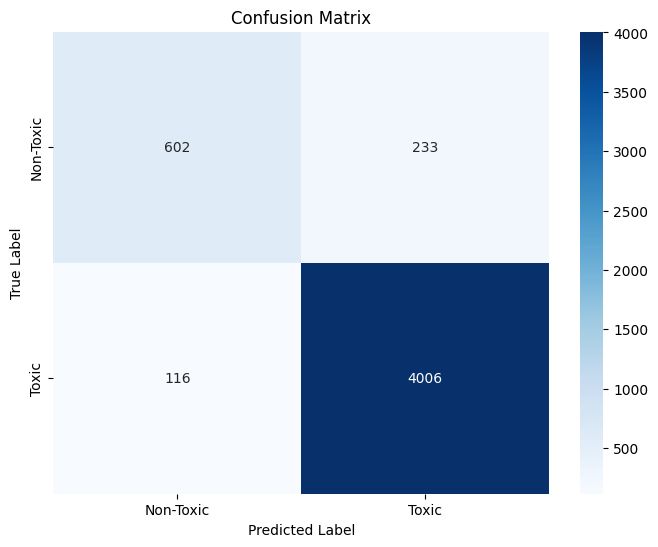

In [ ]:
# Vytvorenie confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predicted_classes)

# Nastavenie popisov
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Non-Toxic', 'Toxic']

# Vytvorenie DataFrame pre confusion matrix s popismi
conf_df = pd.DataFrame(conf_matrix, index=categories, columns=categories)

# Vizualizácia confusion matrix pomocou teplotnej mapy
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
def false_negative_rate(false_negatives, true_positives):
    return false_negatives / (false_negatives + true_positives)
# Vypočítanie falošných negatív
false_negatives = conf_matrix[1][0]
print(false_negatives)
# Vypočítanie počtu skutočných pozitív
true_positives = conf_matrix[1][1]
print(true_positives)
# Výpočet falošnej negatívnej miery
fnr = false_negative_rate(false_negatives, true_positives)

print("Falošná negatívna miera:", fnr)

166
4006
Falošná negatívna miera: 0.02814168
